In [338]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import pyplot

pd.set_option("display.precision", 2)
%matplotlib inline

import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance

In [339]:
df = pd.read_csv("/home/leslie/code/melanoma_files/train.csv")

In [340]:
df["patient_id"].value_counts()

IP_4938382    115
IP_4382720    115
IP_4479736    115
IP_7279968    115
IP_0656529    114
             ... 
IP_9685257      3
IP_2105363      3
IP_3419097      3
IP_0491775      3
IP_8335299      2
Name: patient_id, Length: 2056, dtype: int64

In [341]:
df.anatom_site_general_challenge.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

In [342]:
df.head(8)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0


In [343]:
# Creating new columns for "female", "male", "head/neck", etc.
df["female"] = [1 if x == 'female' else 0 for x in df['sex']]
df["male"] = [1 if x == 'male' else 0 for x in df['sex']]

df["head_neck"] = [1 if x == 'head/neck' else 0 for x in df['anatom_site_general_challenge']]
df["torso"] = [1 if x == 'torso' else 0 for x in df['anatom_site_general_challenge']]
df["lower_extremity"] = [1 if x == 'lower extremity' else 0 for x in df['anatom_site_general_challenge']]
df["upper_extremity"] = [1 if x == 'upper extremity' else 0 for x in df['anatom_site_general_challenge']]
df["palms_soles"] = [1 if x == 'palms/soles' else 0 for x in df['anatom_site_general_challenge']]
df["oral_genital"] = [1 if x == 'oral/genital' else 0 for x in df['anatom_site_general_challenge']]  

In [348]:
df = df.assign(min_visit_age = df.groupby('patient_id').age_approx.transform('min'))
df = df.assign(max_visit_age = df.groupby('patient_id').age_approx.transform('max'))
df = df.assign(total_visits = df.groupby('patient_id').age_approx.transform('count'))

df = df.assign(images_torso = df.groupby(['patient_id'])['torso'].transform('sum'))
df = df.assign(images_lower_ex = df.groupby(['patient_id'])['lower_extremity'].transform('sum'))
df = df.assign(images_upper_ex = df.groupby(['patient_id'])['upper_extremity'].transform('sum'))
df = df.assign(images_head_neck = df.groupby(['patient_id'])['head_neck'].transform('sum'))
df = df.assign(images_palms_soles = df.groupby(['patient_id'])['palms_soles'].transform('sum'))
df = df.assign(images_oral_gen = df.groupby(['patient_id'])['oral_genital'].transform('sum'))


In [349]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,female,male,...,oral_genital,min_visit_age,max_visit_age,total_visits,images_torso,images_lower_ex,images_upper_ex,images_head_neck,images_palms_soles,images_oral_gen
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,1,...,0,45.0,45.0,115,77,2,20,16,0,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,1,0,...,0,45.0,45.0,24,15,1,5,3,0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,1,0,...,0,50.0,55.0,5,2,3,0,0,0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,1,0,...,0,40.0,45.0,22,9,6,3,1,3,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,1,0,...,0,55.0,55.0,20,8,3,8,1,0,0


In [350]:
# df.loc[df["patient_id"] == "IP_1870306"]

In [351]:
# Getting rid of a few columns like "image_name", etc.
df=df.drop(columns=['image_name', 'sex', 'anatom_site_general_challenge','benign_malignant','diagnosis'])

In [352]:
df.head()

,patient_id,age_approx,target,female,male,head_neck,torso,lower_extremity,upper_extremity,palms_soles,oral_genital,min_visit_age,max_visit_age,total_visits,images_torso,images_lower_ex,images_upper_ex,images_head_neck,images_palms_soles,images_oral_gen
0,IP_7279968,45.0,0,0,1,1,0,0,0,0,0,45.0,45.0,115,77,2,20,16,0,0
1,IP_3075186,45.0,0,1,0,0,0,0,1,0,0,45.0,45.0,24,15,1,5,3,0,0
2,IP_2842074,50.0,0,1,0,0,0,1,0,0,0,50.0,55.0,5,2,3,0,0,0,0
3,IP_6890425,45.0,0,1,0,1,0,0,0,0,0,40.0,45.0,22,9,6,3,1,3,0
4,IP_8723313,55.0,0,1,0,0,0,0,1,0,0,55.0,55.0,20,8,3,8,1,0,0


In [353]:
# NOTE: When going from string to integer, zeroes in front of id's will be removed

df["patient_id"] = pd.to_numeric(df["patient_id"].str[3:])

In [354]:
df.head()

,patient_id,age_approx,target,female,male,head_neck,torso,lower_extremity,upper_extremity,palms_soles,oral_genital,min_visit_age,max_visit_age,total_visits,images_torso,images_lower_ex,images_upper_ex,images_head_neck,images_palms_soles,images_oral_gen
0,7279968,45.0,0,0,1,1,0,0,0,0,0,45.0,45.0,115,77,2,20,16,0,0
1,3075186,45.0,0,1,0,0,0,0,1,0,0,45.0,45.0,24,15,1,5,3,0,0
2,2842074,50.0,0,1,0,0,0,1,0,0,0,50.0,55.0,5,2,3,0,0,0,0
3,6890425,45.0,0,1,0,1,0,0,0,0,0,40.0,45.0,22,9,6,3,1,3,0
4,8723313,55.0,0,1,0,0,0,0,1,0,0,55.0,55.0,20,8,3,8,1,0,0


In [355]:
df.dtypes

patient_id              int64
age_approx            float64
target                  int64
female                  int64
male                    int64
head_neck               int64
torso                   int64
lower_extremity         int64
upper_extremity         int64
palms_soles             int64
oral_genital            int64
min_visit_age         float64
max_visit_age         float64
total_visits            int64
images_torso            int64
images_lower_ex         int64
images_upper_ex         int64
images_head_neck        int64
images_palms_soles      int64
images_oral_gen         int64
dtype: object

In [356]:
unique_patients = set()

for index in range(len(df)):
    unique_patients.add(df["patient_id"].iloc[index])
    
unique_patients = list(unique_patients)

In [357]:
random.shuffle(unique_patients)
train_size = int(round(len(unique_patients)*0.8, 0))

In [358]:
train = unique_patients[:train_size]
test = unique_patients[train_size:]

x_train = df[df["patient_id"].isin(train)]
x_test = df[df["patient_id"].isin(test)]

y_train = x_train.target
y_test = x_test.target

In [359]:
x_train=x_train.drop(columns=['target'])
x_test=x_test.drop(columns=['target'])

In [360]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(26275, 19)
(26275,)
(6851, 19)
(6851,)


In [361]:
# fit model no training data
model = XGBClassifier()
model.fit(x_train, y_train)

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [362]:
# make predictions for test data
y_pred = model.predict(x_test)
# predictions = [round(value) for value in y_pred]

In [368]:
print("y_pred:") 
print(y_pred)
print("\ny_pred minimum: " + str(y_pred.min()))
print("y_pred maximum: " + str(y_pred.max()))
print(len(y_pred))
print(sum(y_pred))

y_pred:
[0 0 0 ... 0 0 0]

y_pred minimum: 0
y_pred maximum: 1
6851
2


In [369]:
mean_squared_error(y_test, y_pred)

0.02101882936797548

In [370]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.90%


In [371]:
unique_pred = []

for element in y_pred: 
    if element not in unique_pred:
        unique_pred.append(element)

print(unique_pred)

[0, 1]


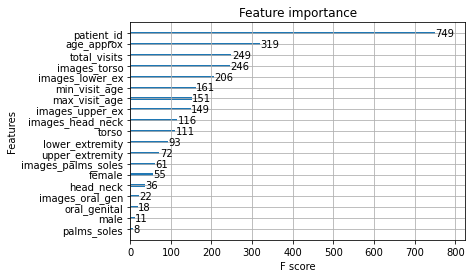

In [372]:
plot_importance(model)
pyplot.show()

# Attempt with test.csv

In [387]:
df = pd.read_csv("/home/leslie/code/melanoma_files/test.csv")
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [388]:
df_image_ids = df['image_name']
df_image_ids

0        ISIC_0052060
1        ISIC_0052349
2        ISIC_0058510
3        ISIC_0073313
4        ISIC_0073502
             ...     
10977    ISIC_9992485
10978    ISIC_9996992
10979    ISIC_9997917
10980    ISIC_9998234
10981    ISIC_9999302
Name: image_name, Length: 10982, dtype: object

In [389]:
# Creating new columns for "female", "male", "head/neck", etc.
df["female"] = [1 if x == 'female' else 0 for x in df['sex']]
df["male"] = [1 if x == 'male' else 0 for x in df['sex']]

df["head_neck"] = [1 if x == 'head/neck' else 0 for x in df['anatom_site_general_challenge']]
df["torso"] = [1 if x == 'torso' else 0 for x in df['anatom_site_general_challenge']]
df["lower_extremity"] = [1 if x == 'lower extremity' else 0 for x in df['anatom_site_general_challenge']]
df["upper_extremity"] = [1 if x == 'upper extremity' else 0 for x in df['anatom_site_general_challenge']]
df["palms_soles"] = [1 if x == 'palms/soles' else 0 for x in df['anatom_site_general_challenge']]
df["oral_genital"] = [1 if x == 'oral/genital' else 0 for x in df['anatom_site_general_challenge']]      



In [390]:
df = df.assign(min_visit_age = df.groupby('patient_id').age_approx.transform('min'))
df = df.assign(max_visit_age = df.groupby('patient_id').age_approx.transform('max'))
df = df.assign(total_visits = df.groupby('patient_id').age_approx.transform('count'))

df = df.assign(images_torso = df.groupby(['patient_id'])['torso'].transform('sum'))
df = df.assign(images_lower_ex = df.groupby(['patient_id'])['lower_extremity'].transform('sum'))
df = df.assign(images_upper_ex = df.groupby(['patient_id'])['upper_extremity'].transform('sum'))
df = df.assign(images_head_neck = df.groupby(['patient_id'])['head_neck'].transform('sum'))
df = df.assign(images_palms_soles = df.groupby(['patient_id'])['palms_soles'].transform('sum'))
df = df.assign(images_oral_gen = df.groupby(['patient_id'])['oral_genital'].transform('sum'))

In [391]:
# Getting rid of a few columns like "image_name", etc.
df=df.drop(columns=['image_name', 'sex', 'anatom_site_general_challenge'])

In [392]:
df["patient_id"] = pd.to_numeric(df["patient_id"].str[3:])

In [393]:
y_pred = model.predict(df)

In [394]:
print("y_pred:") 
print(y_pred)
print("\ny_pred minimum: " + str(y_pred.min()))
print("y_pred maximum: " + str(y_pred.max()))

y_pred:
[0 0 0 ... 0 0 0]

y_pred minimum: 0
y_pred maximum: 1


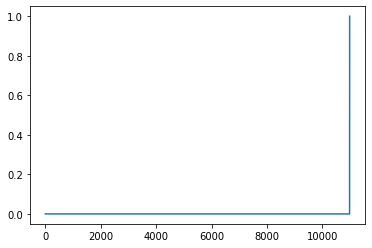

In [395]:
plt.plot(np.sort(y_pred))

(array([1.0979e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

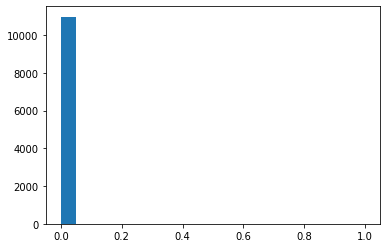

In [396]:
plt.hist(y_pred, bins = 20)

In [397]:
df_y = pd.DataFrame(data=y_pred,columns=['target'])

In [398]:
result = pd.concat([df_image_ids, df_y], axis=1, sort=False)

In [399]:
result

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0
...,...,...
10977,ISIC_9992485,0
10978,ISIC_9996992,0
10979,ISIC_9997917,0
10980,ISIC_9998234,0


In [403]:
result.to_csv('submission.csv', index = False, header = 1)